## Download Dataset through Kaggle API

In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

**You need to upload kaggle.json file for this command to work**
More: https://www.kaggle.com/docs/api

In [6]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

100% 148M/149M [00:07<00:00, 23.8MB/s]
100% 149M/149M [00:07<00:00, 20.5MB/s]


In [7]:
# unzip
import zipfile

def unzip_folder(zip_file_path, extract_to_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_path)

# Example usage:
zip_file_path = '/content/brain-tumor-mri-dataset.zip'
extract_to_path = '/content/brain-tumor-mri-dataset'
unzip_folder(zip_file_path, extract_to_path)

Alternative: upload the folder in your drive and then access dataset through drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Import needed libraries

In [ ]:
# General Imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Neural Network imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam

# Image augmentation importrs
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomContrast
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomTranslation

# Training Model callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

SEED = 110

## Loading dataset

**Functions for reading dataset**

In [ ]:
def get_data_labels(directory, shouldShuffle=True, random_state=0):
    from sklearn.utils import shuffle
    data_path = []
    data_index = []
    label_dict = {label: index for index, label in enumerate(sorted(os.listdir(directory)))}
    for label, index in label_dict.items():
        label_dir = os.path.join(directory, label)
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_index.append(index)
    if shouldShuffle:
        data_path, data_index = shuffle(data_path, data_index, random_state=random_state)
    return data_path, data_index

def parse_function(filename, label, image_size, n_channels):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, n_channels)
    image = tf.image.resize(image, image_size)
    return image, label

def get_dataset(paths, labels, image_size, n_channels=1, num_classes=4, batch_size=32):
    path_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    image_label_ds = path_ds.map(lambda path, label: parse_function(path, label, image_size, n_channels),
                                 num_parallel_calls=tf.data.AUTOTUNE)

    return image_label_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
USER_PATH = "/content/brain-tumor-mri-dataset"
train_paths, train_index = get_data_labels(USER_PATH + '/Training', random_state=SEED)
test_paths, test_index = get_data_labels(USER_PATH + '/Testing', random_state=SEED)
validation_paths, test_paths, validation_index, test_index = train_test_split(test_paths, test_index, test_size = 0.45, random_state = 4)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nValidation')
print(f'Number of Paths: {len(validation_paths)}')
print(f'Number of Labels: {len(validation_index)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')


# Prepare datasets with 4 classes and grayscale
batch_size = 50
image_dim = (168, 168)
train_ds = get_dataset(train_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
validation_ds = get_dataset(validation_paths, validation_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)



Training
Number of Paths: 5712
Number of Labels: 5712

Validation
Number of Paths: 721
Number of Labels: 721

Testing
Number of Paths: 590
Number of Labels: 590


In [ ]:
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
class_names = list(class_mappings.keys())

## Plotting Data Distribution

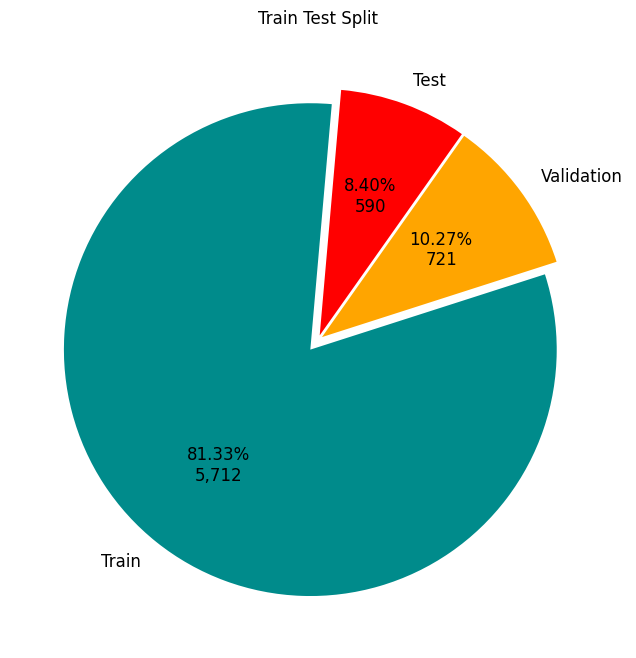

In [ ]:
plt.figure(figsize=(15, 8))
plt.title('Train Test Split')
plt.pie(
    [len(train_index), len(validation_index), len(test_index)],
    labels=['Train', 'Validation', 'Test'],
    colors=['darkcyan', 'orange', 'red'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum([len(train_index), len(validation_index), len(test_index)]) / 100),
    explode=(0.05, 0.02, 0.02),
    startangle=85,
    textprops={'fontsize': 12}
)
plt.show()

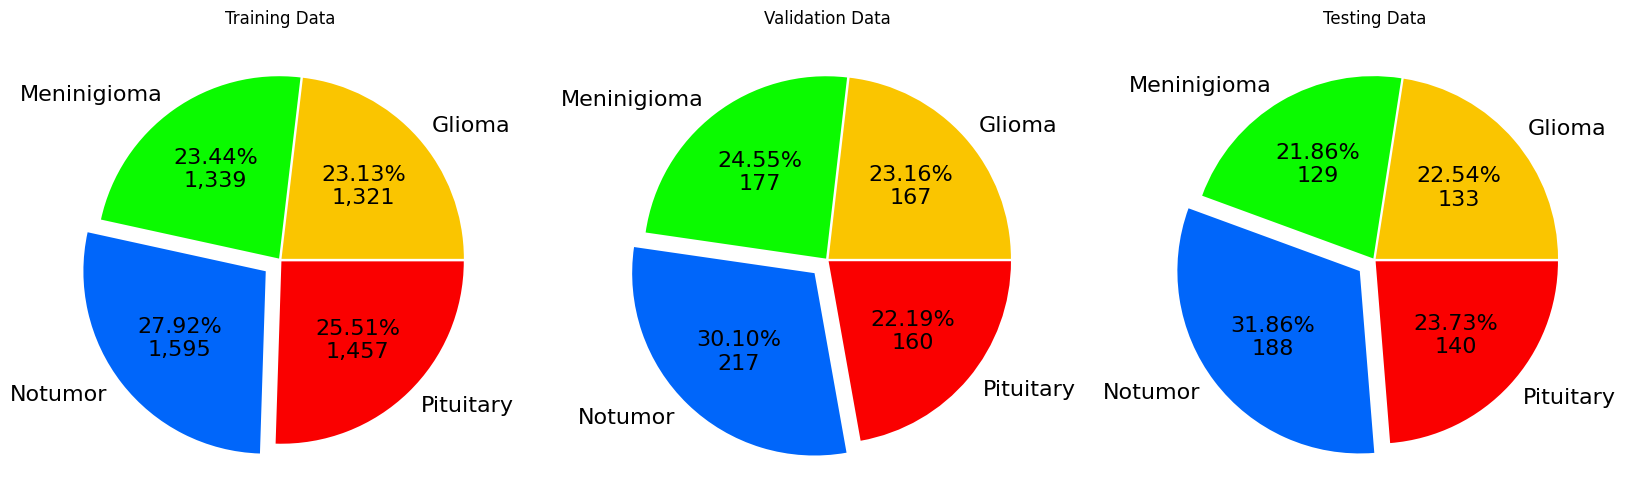

In [ ]:
_, ax = plt.subplots(ncols=3, figsize=(20, 14))

# Plotting training data types
class_counts = [len([x for x in train_index if x == label]) for label in set(train_index)]
ax[0].set_title('Training Data')
ax[0].pie(
    class_counts,
    labels=[label for label in class_names],
    colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=(0.01, 0.01, 0.1, 0.01),
    textprops={'fontsize': 16}
)

# Plotting validation data types
class_counts = [len([x for x in validation_index if x == label]) for label in set(validation_index)]
ax[1].set_title('Validation Data')
ax[1].pie(
    class_counts,
    labels=[label for label in class_names],
    colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=(0.01, 0.01, 0.1, 0.01),
    textprops={'fontsize': 16}
)

# Plotting testing data types
class_counts = [len([x for x in test_index if x == label]) for label in set(test_index)]
ax[2].set_title('Testing Data')
ax[2].pie(
    class_counts,
    labels=[label for label in class_names],
    colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=(0.01, 0.01, 0.1, 0.01),
    textprops={'fontsize': 16}
)

plt.show()

## Displaying Images

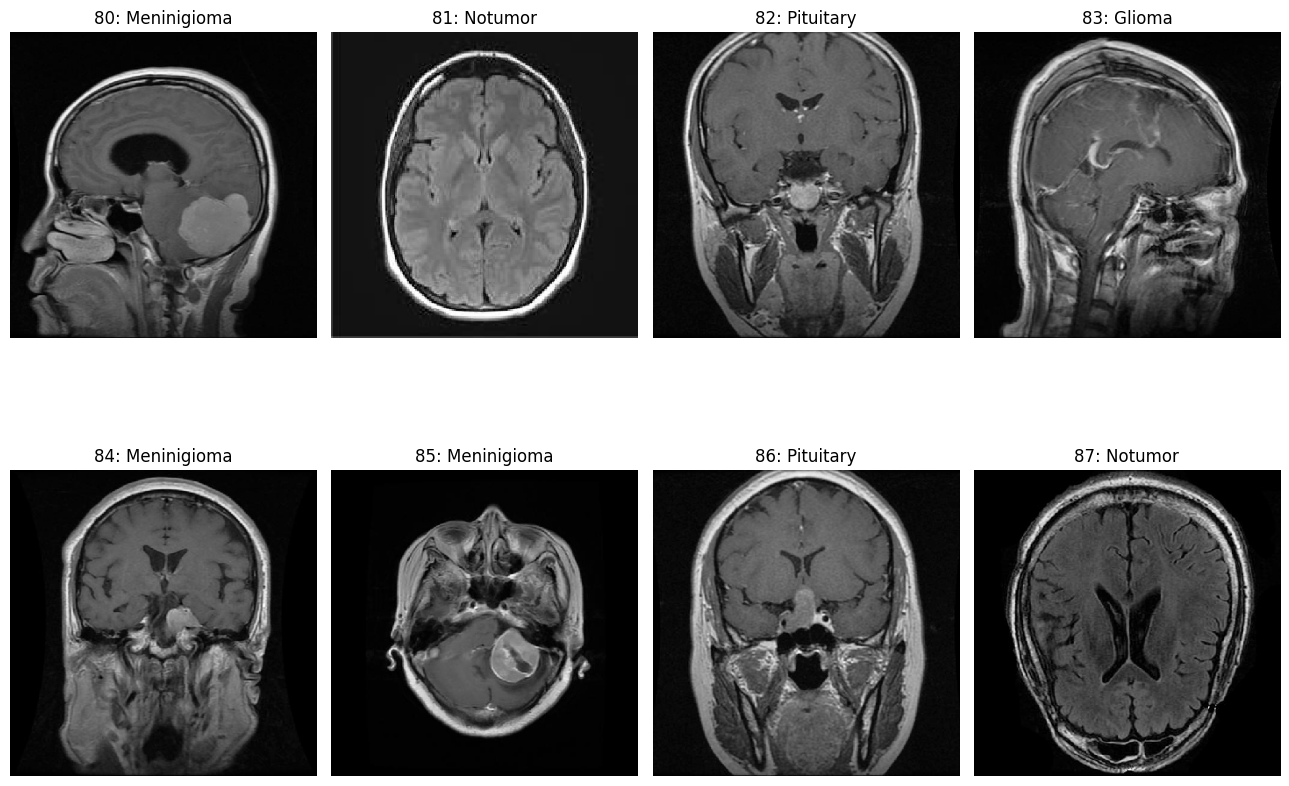

In [ ]:
# Function to display a list of images based on the given index
def show_images(paths, label_paths, class_mappings, index_list=range(10), im_size=250, figsize=(12, 8)):

    num_images = len(index_list)
    num_rows = (num_images + 3) // 4
    index_to_class = {v: k for k, v in class_mappings.items()}
    _, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()

    for i, index in enumerate(index_list):
        if i >= num_images:
            break
        image = load_img(paths[index], target_size=(im_size, im_size), color_mode='grayscale')
        ax[i].imshow(image, cmap='Greys_r')
        class_name = index_to_class[label_paths[index]]
        ax[i].set_title(f'{index}: {class_name}')
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

  # Function to display augmented images


show_images(train_paths, train_index, class_mappings, im_size=350, figsize=(13,10),
            index_list=range(80, 88))

## Augmentation, normalization and one-hotencoding

In [ ]:
# data augmentation
data_augmentation = Sequential([
    # RandomFlip("horizontal_and_vertical"),
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# augmentation & normalization
def preprocess_train(image, label):
    # Apply data augmentation and Normalize
    image = data_augmentation(image) / 255.0
    return image, label

def preprocess_test(image, label):
    return image / 255.0, label

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

In [ ]:
# Apply transformation to training, validation & testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train)
test_ds_preprocessed = test_ds.map(preprocess_test)
validation_ds_preprocessed = validation_ds.map(preprocess_test)

In [ ]:
# one-hot encode labels
train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
validation_ds_preprocessed = validation_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)

## Setting up the model

In [ ]:
# Classes and Image shape: height, width, grayscale
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1)

# Training epochs and batch size
epochs = 15
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')


Number of Classes: 4
Image shape: (168, 168, 1)
Epochs: 15
Batch size: 50


In [ ]:
# Building model
model = Sequential([
    # Input tensor shape
    Input(shape=image_shape),

    # Convolutional layer 1
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # # Convolutional layer 2
    # Conv2D(64, (5, 5), activation="relu"),
    # MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 4
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    # Dense layers
    Dense(128, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Model summary
model.summary()

# Compilng model with Adam optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 164, 164, 64)      1664      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 82, 82, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 80, 80, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 40, 40, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 38, 38, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 19, 19, 128)      

## Training

In [ ]:
# Callbacks for improved covergence of gradient and best test accuracy
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('/content/tumor_prediction_model_2', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history = model.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=validation_ds_preprocessed,
    callbacks=[model_rlr, model_mc],
    verbose=True
)

Epoch 1/15
115/115 [==============================] - 29s 220ms/step - loss: 0.7539 - accuracy: 0.6947 - val_loss: 0.9186 - val_accuracy: 0.6338 - lr: 0.0010
Epoch 2/15
115/115 [==============================] - 26s 225ms/step - loss: 0.4577 - accuracy: 0.8291 - val_loss: 0.7483 - val_accuracy: 0.7074 - lr: 0.0010
Epoch 3/15
115/115 [==============================] - 25s 218ms/step - loss: 0.3523 - accuracy: 0.8634 - val_loss: 0.4076 - val_accuracy: 0.8322 - lr: 0.0010
Epoch 4/15
115/115 [==============================] - 25s 217ms/step - loss: 0.2675 - accuracy: 0.9067 - val_loss: 0.3397 - val_accuracy: 0.8766 - lr: 0.0010
Epoch 5/15
115/115 [==============================] - 25s 217ms/step - loss: 0.2183 - accuracy: 0.9221 - val_loss: 0.2263 - val_accuracy: 0.9140 - lr: 0.0010
Epoch 6/15
115/115 [==============================] - 24s 210ms/step - loss: 0.1646 - accuracy: 0.9429 - val_loss: 0.2609 - val_accuracy: 0.9043 - lr: 0.0010
Epoch 7/15
115/115 [==============================] 

## Testing

In [ ]:
# Loading saved model
model = load_model('/content/tumor_prediction_model_2')

# Evaluate model and test data accuracy
test_loss, test_acc = model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")

12/12 [==============================] - 1s 87ms/step - loss: 0.1090 - accuracy: 0.9729
Test accuracy: 97.2881%


## Plotting: Accuracy and Loss over epochs

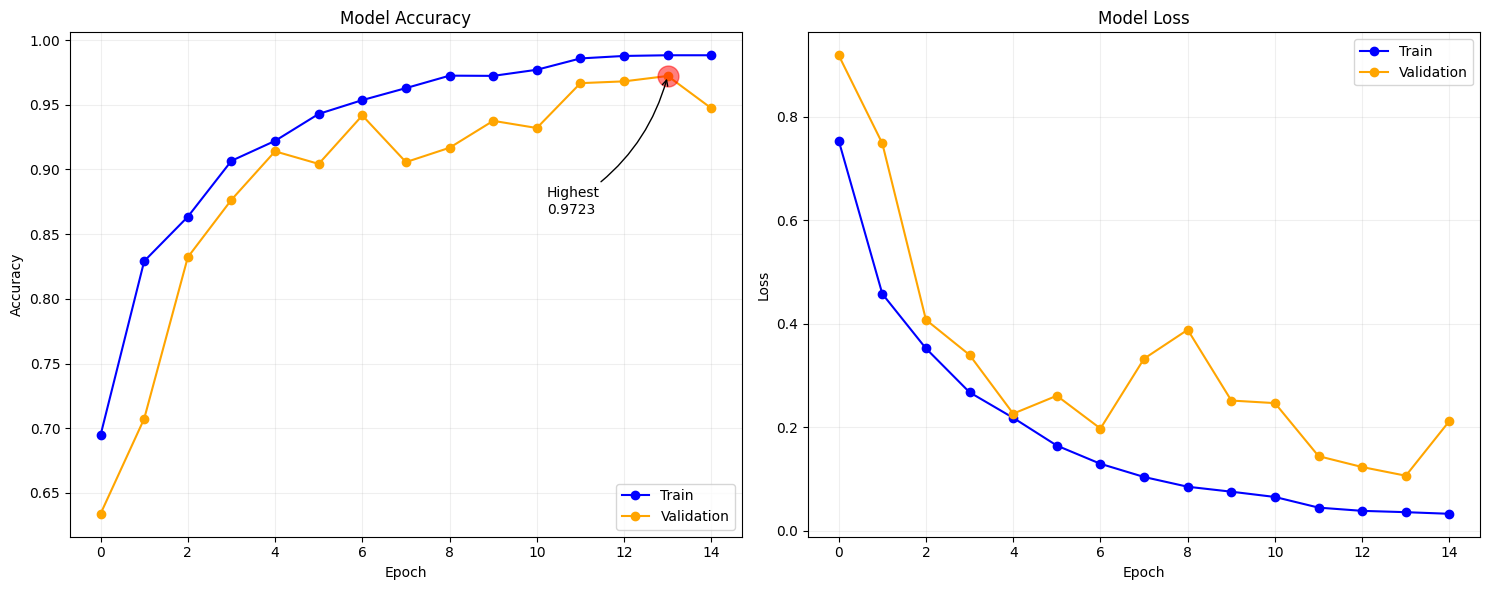

In [ ]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plotting training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'], marker='o', linestyle='-', color='blue')
ax[0].plot(history.history['val_accuracy'], marker='o', linestyle='-', color='orange')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'], loc='lower right')
ax[0].grid(alpha=0.2)

# Plotting training and validation loss over epochs
ax[1].plot(history.history['loss'], marker='o', linestyle='-', color='blue')
ax[1].plot(history.history['val_loss'], marker='o', linestyle='-', color='orange')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'], loc='upper right')
ax[1].grid(alpha=0.2)

# Highlight highest validation accuracy
min_val_acc_epoch = np.argmax(history.history['val_accuracy'])
min_val_acc = np.max(history.history['val_accuracy'])
ax[0].plot(min_val_acc_epoch, min_val_acc, 'ro', markersize=15, alpha=0.5)
ax[0].annotate(f'Highest\n{min_val_acc:.4f}', xy=(min_val_acc_epoch, min_val_acc),
               xytext=(min_val_acc_epoch - 100, min_val_acc - 100), textcoords='offset points',
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.show()

## Confusion Matrix

In [ ]:
# Using test data for true and preductions
true_labels = []
predicted_labels = []

# Iterate over dataset to collect predictions and true labels
# Unbatch to get sample-wise prediction
for images, labels in test_ds_preprocessed.unbatch():
    # Store true labels (Convert one-hot to index)
    true_label = np.argmax(labels.numpy())
    true_labels.append(true_label)

    # Get model prediction (Predict expects batch dimension)
    pred = model.predict(tf.expand_dims(images, 0), verbose=False)
    predicted_label = np.argmax(pred)
    predicted_labels.append(predicted_label)

In [ ]:
def plot_confusion_matrix(true_labels, predicted_labels, class_mappings, metrics=False, cmap='Blues'):
    # Compute  confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    # Mapping of indices to class names in class_mappings
    plt.xticks(ticks=np.arange(num_classes) + 0.5, labels=class_mappings.keys(), ha='center')
    plt.yticks(ticks=np.arange(num_classes) + 0.5, labels=class_mappings.keys(), va='center')
    plt.show()

    if metrics:
        # Precision, Recall, and F1-Score for each class & Overall accuracy
        precision = np.diag(cm) / np.sum(cm, axis=0)
        recall = np.diag(cm) / np.sum(cm, axis=1)
        f1_scores = 2 * precision * recall / (precision + recall)
        accuracy = np.sum(np.diag(cm)) / np.sum(cm)

        print("Class-wise metrics:")
        for i in range(len(class_mappings)):
            class_name = list(class_mappings.keys())[i]
            print(f"\033[94mClass: {class_name}\033[0m")
            print(f"Precision: {precision[i]:.4f}")
            print(f"Recall: {recall[i]:.4f}")
            print(f"F1-Score: {f1_scores[i]:.4f}\n")

        print(f"\033[92mOverall Accuracy: {accuracy:.4f}\033[0m")

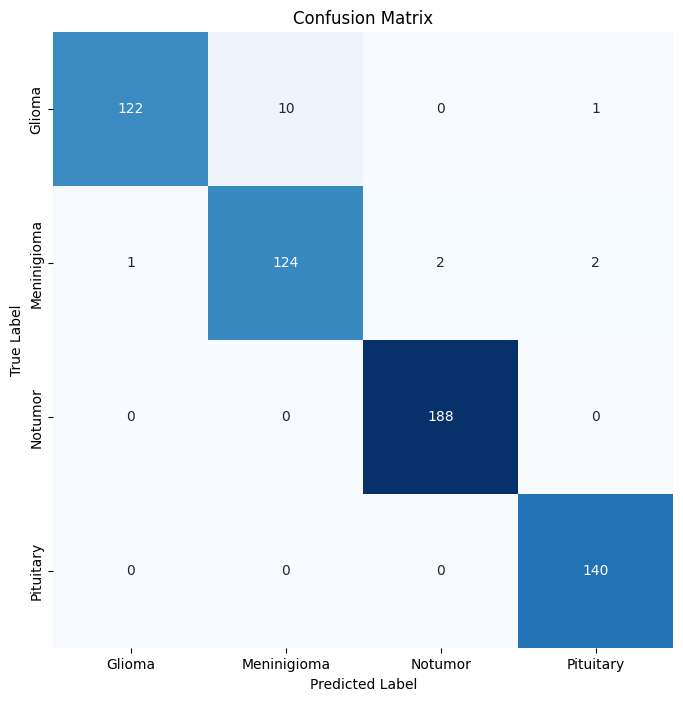

Class-wise metrics:
Class: Glioma
Precision: 0.9919
Recall: 0.9173
F1-Score: 0.9531

Class: Meninigioma
Precision: 0.9254
Recall: 0.9612
F1-Score: 0.9430

Class: Notumor
Precision: 0.9895
Recall: 1.0000
F1-Score: 0.9947

Class: Pituitary
Precision: 0.9790
Recall: 1.0000
F1-Score: 0.9894

Overall Accuracy: 0.9729


In [ ]:
plot_confusion_matrix(true_labels,
                      predicted_labels,
                      class_mappings,
                      metrics=True)